In [1]:
import sys, os
COLAB = 'google.colab' in sys.modules 
if COLAB and 'procgen-tools' not in os.getcwd():
    %pip install git+https://github.com/UlisseMini/procgen-tools.git
    %pip install -r requirements.txt

In [2]:
%load_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from procgen import ProcgenGym3Env
from procgen_tools import maze
from procgen_tools.models import load_policy
import torch
from IPython import display
import pickle


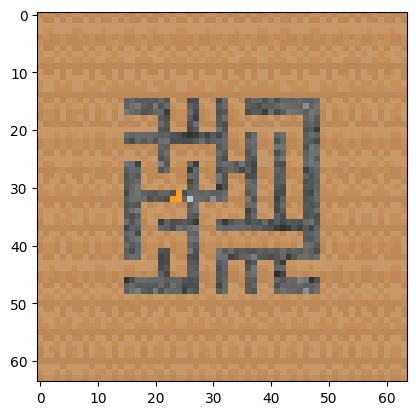

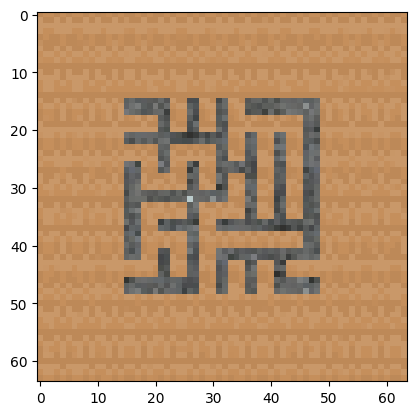

In [3]:
# num is the number of environments to create in the vec env
# num_levels is the number of levels to sample from (0 for infinite, 1 for deterministic)
num_mazes = 2
filepath = f'../mazes/{num_mazes}.pkl'
venv = ProcgenGym3Env(
    num=num_mazes, env_name='maze', num_levels=1, start_level=0,
    distribution_mode='hard', num_threads=1, render_mode="rgb_array",
)
venv = maze.wrap_venv(venv)

try:
    with open(filepath, 'rb') as f:
        state_bytes_list = pickle.load(f)
        if len(state_bytes_list) != venv.num_envs:
            print(f'WARN: saved {len(state_bytes_list)} envs but num_envs is {venv.num_envs}')
        else:
            venv.env.callmethod('set_state', state_bytes_list)

except FileNotFoundError:
    print(f'No {filepath} file exists, generating venv from scratch')
        

obs = venv.reset()
# plot all the envs in the vectorized env
for i in range(obs.shape[0]):
    plt.imshow(obs[i].transpose(1, 2, 0))
    plt.show()

## Edit the maze interactively

Using the magic `maze.grid_editor` function!
Clicking in the maze changes walls to empty space and vise versa.
If you click the cheese it'll disappear and reappear where you click next.

In [4]:
maze.venv_editor(venv)

In [ ]:
with open(filepath, 'wb') as f:
    pickle.dump(venv.env.callmethod("get_state"), f)

## Run the model on the new maze

In [5]:
if COLAB:
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

In [6]:
# download from https://drive.google.com/file/d/1db1qJn_ZM49CUcA1k7uSMdsdiAQ4eR5a/view?usp=share_link
policy = load_policy('../trained_models/model_rand_region_5.pth', action_size=venv.action_space.n, device=torch.device('cpu'))

KeyboardInterrupt: 

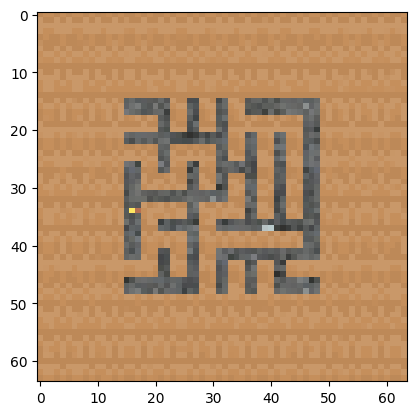

In [7]:
done = np.zeros(venv.num_envs)
obs = venv.reset()
max_steps = 70

for i in range(max_steps):
    if all(done): break
    policy.eval()
    p, v = policy(torch.FloatTensor(obs))
    act = p.sample().numpy()
    #act = p.probs.argmax(dim=-1).numpy()
    obs, rew, done_now, info = venv.step(act)
    done = np.logical_or(done, done_now) # TODO: Don't keep running finished envs 

    if not all(done): # don't show last frame (new maze)
        plt.imshow(obs[0].transpose(1,2,0)) # agent view
        #plt.imshow(info[0]['rgb'])
        display.display(plt.gcf())
        display.clear_output(wait=True)
